In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import relativedelta
import matplotlib.dates as mdates
import numpy as np
%matplotlib inline

In [2]:
bls_1948_present = pd.read_excel('unemployment.xlsx',skiprows=11, index_col='Year').unstack()
bls_prev_years = pd.read_excel('unemployment.xlsx', sheet_name=1, header=None, names=['Date','Unemployment Rate'])
bls_1948_present = bls_1948_present.reset_index(name='Unemployment Rate').dropna()
bls_1948_present.rename(columns={'level_0':'Month'}, inplace=True)

In [3]:
bls_1948_present['Date'] = bls_1948_present.apply(lambda x: " ".join([x['Month'],str(int(x['Year']))]), axis=1)

In [4]:
bls_1948_present['Date'] = pd.to_datetime(bls_1948_present['Date'])
bls_1948_present = bls_1948_present[['Date','Unemployment Rate']]

In [5]:
unemployment = bls_prev_years.append(bls_1948_present).sort_values('Date').reset_index(drop=True)

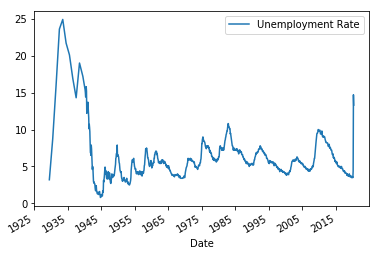

In [6]:
unemployment.plot(x='Date',y='Unemployment Rate')

In [7]:
start_dates = ['December 2007', 'September 1929', 'March 2020']
events = ['Great Recession', 'Great Depression', 'COVID-19']
legend = zip(events, start_dates)
legend = [' - '.join(x) for x in list(legend)]
start_dates = pd.to_datetime(start_dates)
event_df = pd.DataFrame({'Start Date':start_dates, 'Event':events})

In [8]:
unemployment[unemployment['Date']<event_df.iloc[0]['Start Date']].sort_values('Date', ascending=False).iloc[0]['Unemployment Rate']

4.7

In [9]:
def find_unemployment_recovery(start_date, unemployment):
    '''
    Returns earliest unemployment recovery date, start_index, and end_index from given date of recession.
    Takes the immediately previous unemployment rate as the "pre-recession" unemployment rate.
    
    Assumes data has a Date column and an Unemployment Rate column.
    '''
    
    unemployment = unemployment.sort_values('Date')
    
    # Find data from dates afterwards to consider
    post_recession = unemployment[unemployment['Date']>=start_date].sort_values('Date')
    
    # Find immediate previous unemployment rate
    prerecession_rate = unemployment[unemployment['Date']<start_date].sort_values('Date', ascending=False).iloc[0]['Unemployment Rate']
    
    # Find first date when this rate is recovered
    try:
        recovery_date = post_recession[post_recession['Unemployment Rate'] <= prerecession_rate].iloc[0].Date
        end_index = post_recession[post_recession['Unemployment Rate'] <= prerecession_rate].sort_values('Date').index[0]
    except: # if there is no recovery yet...
        recovery_date = 'Not Recovered'
        end_index = unemployment.index[-1]

    start_index = unemployment[unemployment['Date']>=start_date].sort_values('Date').index[0]
    
    
    
    return start_date, recovery_date, start_index, end_index

In [11]:
plt.style.use('fivethirtyeight')

In [19]:
!rm ~/.matplotlib/fontList.cache

rm: /Users/michelleho/.matplotlib/fontList.cache: No such file or directory


/Users/michelleho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/michelleho/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


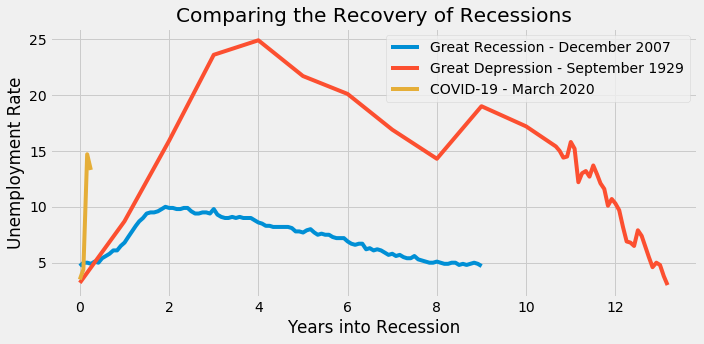

In [19]:
fig = plt.Figure()
longest_recession = np.timedelta64(1,'D')
for date in start_dates:
    start_date, recovery_date, start_index, end_index = find_unemployment_recovery(date, unemployment)
#     print(start_date, recovery_date, start_index, end_index)
    event_data = unemployment[start_index-1:end_index+1]
    event_data['days_in'] = event_data['Date']-event_data.iloc[0]['Date']
    event_data['Years into Recession'] = event_data['days_in']/np.timedelta64(1,'Y')
    event_data.plot(x='Years into Recession',y='Unemployment Rate',ax=plt.gca(), figsize=(10,5))
    plt.xticks()
    plt.legend(legend)

ax = plt.gca()
ax.grid(True)

ax.set_ylabel('Unemployment Rate')
ax.set_title('Comparing the Recovery of Recessions')
plt.tight_layout()

plt.savefig('unemployment.png')
